### **Mount Google Drive/Parent Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **Install and Import Libraries**

In [ ]:
# Library for image registration and others
!pip install SimpleITK-SimpleElastix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np                                            
import matplotlib.pyplot as plt                 
from google.colab.patches import cv2_imshow
import pandas as pd
import os
import SimpleITK as sitk
from scipy.signal import medfilt, lfilter
from skimage import exposure, metrics
from scipy.stats import multivariate_normal
import pickle

**Image Slice Visualization**

In [ ]:
# Visualize 2D Slice from 3D Image
def slice_show(image, slice_no, title):
  """
  Function to visualiza each slice of the 3D image
  Inputs: 
  image => Sitk Image that need to be visualized,
  slice_no => Slice Number
  title => The title of the Image

  output: Plot Image.

  """ 
  flip = np.flipud(image)
  plt.figure()
  plt.axis('off')
  plt.title(title)
  plt.imshow(flip[:,:,slice_no], cmap='gray') 

**SITK and Numpy Conversion**

In [ ]:
def SITKtoArray(itk_image):
  """
  Function to convert Sitk Image to Numpy Array
  Inputs: 
  itk_image => Sitk Image that needs to be converted,

  output: Converted Numpy Array.

  """ 
  return np.moveaxis(sitk.GetArrayFromImage(itk_image),0,-1)

In [ ]:
def ArraytoSITK(array, reference_image):
  """
  Function to convert Numpy Array to Sitk Image
  Inputs: 
  array => numpy array that needs to be converted,
  reference_image => image which metadata will be copied

  output: Converted sitk image.

  """
  image= sitk.GetImageFromArray(np.moveaxis(array,-1,0))
  image.CopyInformation(reference_image)
  return image

### **Data Loading**

In [ ]:
# Directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/'
train_directory = input_directory+'Training_Set' 
val_directory = input_directory+'Validation_Set'
test_directory = input_directory+'Test_Set'
# Directories where data will be saved
saved_data= input_directory + 'Saved_Data'
saved_data_directory_train= input_directory+'Saved_Data/train'
saved_data_directory_val= input_directory+'Saved_Data/val'
saved_data_directory_test= input_directory+'Saved_Data/test'

In [ ]:
def loadData(directory):
  """
  Function to load data with desired format from a given directory.
  Inputs: 
  directory => either train or val or test data directory,

  output: 3 lists containing images, labels and their names.

  """ 

  labels_metadata = []
  images_metadata = []
  images_names= []
  
  for folders in sorted(os.listdir(directory)):
    images_names.append(folders)
    images_directory = os.path.join(directory, folders)
    for files in sorted(os.listdir(images_directory)):
      if '_seg' in files:
        # Accessing the labels/ground truths
        label_paths = os.path.join(images_directory, files)
        label_data = sitk.ReadImage(label_paths)
        labels_metadata.append(label_data)
      else:
      # if '.DS' not in files:
        # Accessing the images
        image_paths = os.path.join(images_directory, files)
        image_data = sitk.ReadImage(image_paths)
        images_metadata.append(image_data)
  return images_metadata, labels_metadata, images_names

In [ ]:
# Training Images and labels
train_images_metadata = []
train_labels_metadata = []
train_images_metadata, train_labels_metadata, train_images_names = loadData(train_directory)
# Validation Images and labels
val_images_metadata = []
val_labels_metadata = []
val_images_metadata, val_labels_metadata, val_images_names = loadData(val_directory)
# Test Images
test_images_metadata = []
test_images_metadata, _, test_images_names= loadData(test_directory)

In [ ]:
# Check
print(len(train_labels_metadata))
print(len(train_images_metadata))
print(len(val_labels_metadata))
print(len(val_images_metadata))
print(len(test_images_metadata))

10
10
5
5
3


### **Preprocessing Steps**

**Bias Correction**

In [ ]:
def N4BiasCorrection(input_img_metadata):
  """
  Function  for correcting low frequency intensity non-uniformity present in MRI image

  """
  # Mask that specifies which pixels are used to estimate the bias-field  
  sitk_mask = sitk.OtsuThreshold(input_img_metadata, 0, 1, 200)
  # Casting the image to be in Float32 type
  sitk_img_float = sitk.Cast(input_img_metadata, sitk.sitkFloat32)
  # Creating Bias Corrector Filter
  corrector = sitk.N4BiasFieldCorrectionImageFilter()
  # Finally Bias correction is performed
  bias_corrected_img = corrector.Execute(sitk_img_float, sitk_mask)
  return bias_corrected_img

**Denoising**

In [ ]:
def denoise(input_img, kernel_size=3):
  """
  Function that uses a median filter with a given kernel size to denoise the image
  
  """
  return medfilt(input_img, kernel_size)

**Normalization**

In [ ]:
def normalization(input_img):
  """
  Function that normalizes the image in min-max form.
  
  """
  img = input_img.copy()
  # Minimum intensity present in the image
  min_intensity = img.min()
  # Maximum intensity present in the image
  max_intensity = img.max()
  # Image Normalization
  img_normalized = ( input_img - min_intensity ) / ( max_intensity - min_intensity )
  return img_normalized

**CLAHE**

In [ ]:
def apply_clahe(input_img):
  """
  Function that performs contrast-limited adaptive histogram equalization on a given image.
  
  """
  img= input_img.copy()
  # Applying clahe on a given image (library taken from skimage)
  clahe_img = exposure.equalize_adapthist(img, clip_limit=0.01)
  return clahe_img

**Preprocessing**

In [ ]:
def preprocessing(input_img_metadata):
  """
  Function that performs all the preprocessing steps on a given image.
  
  """
  # input_img = np.moveaxis(sitk.GetArrayFromImage(input_img_metadata),0,-1)
  # slice_show(input_img, 121, 'Input Image')
  # Bias Correction
  bias_img = N4BiasCorrection(input_img_metadata)
  bias_corrected_img = np.moveaxis(sitk.GetArrayFromImage(bias_img),0,-1)
  # slice_show(bias_corrected_img, 121, 'Bias Corrected Image')
  # Image Denoising
  denoised_img = denoise(bias_corrected_img)
  # slice_show(denoised_img, 121, 'Denoised Image')
  # Image Noramlization
  normalized_img = normalization(denoised_img)
  # slice_show(normalized_img, 121, 'Normalized Image')
  # Adaptive Histogram Equalization
  clahe_img = apply_clahe(normalized_img)
  # slice_show(clahe_img, 121, 'Clahe Image')
  return clahe_img

### **Preprocessing Pipeline**

**Training Set**

In [ ]:
# Preprocessing training images and storing
train_preprocessed_images = []
for data in train_images_metadata:
  preprocessed_img = preprocessing(data)
  train_preprocessed_images.append(preprocessed_img)

In [ ]:
pickle.dump(train_preprocessed_images, open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/train_preprocessed_images.sav', 'wb'))

In [ ]:
train_preprocessed_images= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/train_preprocessed_images.sav', 'rb'))

In [ ]:
# Storing preprocessed training images
for i in range(len(train_preprocessed_images)): 
  image= ArraytoSITK(train_preprocessed_images[i],train_images_metadata[i])
  sitk.WriteImage(image, saved_data_directory_train+'/'+train_images_names[i]+'_preprocessed.nii.gz')

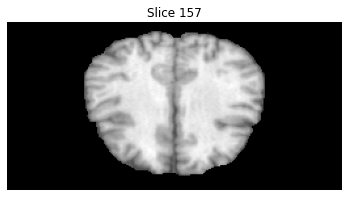

In [ ]:
# Check before preprocessing
slice_show(SITKtoArray(train_images_metadata[0]),157,'Slice 157')

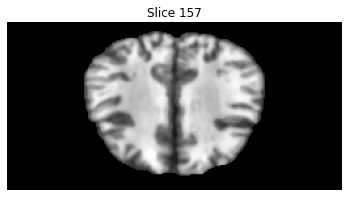

In [ ]:
# Check After preprocessing
slice_show(train_preprocessed_images[0],157,'Slice 157')

**Test Set**

In [ ]:
# Preprocessing test images and storing
test_preprocessed_images = []
for data in test_images_metadata:
  preprocessed_img = preprocessing(data)
  test_preprocessed_images.append(preprocessed_img)

In [ ]:
pickle.dump(test_preprocessed_images, open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/test_preprocessed_images.sav', 'wb'))

In [ ]:
test_preprocessed_images= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Saved_Data/test_preprocessed_images.sav', 'rb'))

In [ ]:
# Storing preprocessed test images
for i in range(len(test_preprocessed_images)): 
  image= ArraytoSITK(test_preprocessed_images[i], test_images_metadata[i])
  sitk.WriteImage(image, saved_data_directory_test+'/'+test_images_names[i]+'_preprocessed.nii.gz')

### **Registration Pipeline**

**Resample Voxel Spacing**

In [ ]:
def resample_volume(image, new_spacing):
  """
  Function  for resampling the voxel-spacing of an image so that both fixed and moving image have same spacing for voxels before registration.
  Inputs:
  image => Image which voxel spacing needs to be resampled,
  new_spacing => desired voxel spacing.

  Output:
  New volume image with desired voxel spacing.

  """
  # Image cast to Float32 mode required
  volume = sitk.Cast(image,sitk.sitkFloat32)
  # Interpolator creation
  interpolator = sitk.sitkLinear
  # Get the current voxel spacing and size
  original_spacing = volume.GetSpacing()
  original_size = volume.GetSize()
  # Resampling
  new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
  return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                        volume.GetOrigin(), new_spacing, volume.GetDirection(), 0,
                        volume.GetPixelID())

In [ ]:
def RegistrationFramework(fixed_preprocessed_images, fixed_images_metadata, moving_preprocessed_images, moving_images_metadata, moving_masks_metadata, parameter_list, output_directory):
  """
  Function for performing Image Registration.
  
  Inputs:
  fixed_preprocessed_images => Fixed Image list(numpy),
  fixed_images_metadata =>  Fixed Image list in Sitk format,
  moving_preprocessed_images => Moving Image list(numpy),
  moving_images_metadata =>  Moving Image list in Sitk format,
  moving_masks_metadata => Ground Truths list of Moving Images in Sitk format,
  parameter_list => Parameters that will be used by elastix for registration,
  output_directory => Directory where registered images will be saved.
  
  """
  for i in range(len(fixed_images_metadata)):
    # Accesing current fixed image from the list
    current_fixed_img = ArraytoSITK(fixed_preprocessed_images[i], fixed_images_metadata[i])
    fixed_output_directory = output_directory + '/' + val_images_names[i]
    if not os.path.exists(fixed_output_directory):
      os.makedirs(fixed_output_directory)
    for j in range(len(moving_images_metadata)):
      # Accesing current moving image from the list
      current_moving = ArraytoSITK(moving_preprocessed_images[j], moving_images_metadata[j])
      # Resampling the voxel spacing of the moving image according to the fixed one
      current_moving_img = resample_volume(current_moving, current_fixed_img.GetSpacing())
      # Registered Images will be saved in this directory
      current_output_directory = fixed_output_directory + '/' + train_images_names[j]
      if not os.path.exists(current_output_directory):
        os.makedirs(current_output_directory)
      output_registered_image = current_output_directory + '/registered_image.nii.gz'

      # Image registration steps using Elastix
      elastixImageFilter = sitk.ElastixImageFilter()
      elastixImageFilter.LogToConsoleOn()
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)
      parameterMapVector = sitk.VectorOfParameterMap()
      # If there are multiple parameter files, all will be appended in the vector
      for p in parameter_list:
        parameterMapVector.append(sitk.ReadParameterFile(p))
      elastixImageFilter.SetParameterMap(parameterMapVector)
      elastixImageFilter.Execute()

      # Accesing the deformation field from the registration performed
      transformed_parameter_map= elastixImageFilter.GetTransformParameterMap()
      sitk.WriteImage(elastixImageFilter.GetResultImage(),output_registered_image)

      # Label Propagation of the moving image to get the labels for fixed images after registration 
      output_transformed_label= current_output_directory +'/transformed_label.nii.gz'

      # Label Propagation using Transformix
      transformixImageFilter = sitk.TransformixImageFilter()
      transformixImageFilter.SetMovingImage(moving_masks_metadata[j])
      transformixImageFilter.SetTransformParameterMap(transformed_parameter_map)
      transformixImageFilter.SetOutputDirectory(current_output_directory)
      transformixImageFilter.Execute()

      # Finally storing the mask images
      sitk.WriteImage(transformixImageFilter.GetResultImage(), output_transformed_label)
      

**Image Registration**

In [ ]:
# Image Registration Pipeline
reg_output_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Registration_Results/'
test_output_directory = reg_output_directory + 'test'

# Parameter that will be used for registration
parameter_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Parameters_Registration_10'
parameter_list = []
for files in sorted(os.listdir(parameter_directory)):
  param_directory = os.path.join(parameter_directory, files)
  parameter_list.append(param_directory)

In [ ]:
# Registration is performed on Test Images 
RegistrationFramework(test_preprocessed_images, test_images_metadata, train_preprocessed_images, train_images_metadata, train_labels_metadata, parameter_list, test_output_directory)

In [ ]:
# parameter_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Parameters_Registration_09'
# parameter_list = []
# for files in sorted(os.listdir(parameter_directory)):
#   param_directory = os.path.join(parameter_directory, files)
#   parameter_list.append(param_directory)

**Test Data**

In [ ]:
# Propagated Label Candiadate Lists for each registered images without voxel-spacing resampling
transformed_labels=[]
for folders in sorted(os.listdir(reg_output_directory + 'test')):
  labels=[]
  for candidates in sorted(os.listdir(reg_output_directory+'test/'+folders)):
    labels.append(sitk.ReadImage(reg_output_directory+'test/'+folders+'/'+candidates+'/transformed_label.nii.gz'))
  transformed_labels.append(labels)

In [ ]:
# Propagated Label Candiadate Lists in numpy array format for each registered images without voxel-spacing resampling
transformed_labels_data=[]
for elements in transformed_labels: 
  labels=[]
  for candidates in elements: 
    labels.append(SITKtoArray(candidates).astype(np.uint8))
  transformed_labels_data.append(labels)
      

## **Segmentation Pipeline**

In [ ]:
# Candiadate Lists for each registered images without voxel-spacing resampling
registered_images = []
for folders in sorted(os.listdir(reg_output_directory + 'val')):
  images = []
  for candidates in sorted(os.listdir(reg_output_directory+'val/'+folders)):
    images.append(SITKtoArray(sitk.ReadImage(reg_output_directory+'val/'+folders+'/'+candidates+'/registered_image.nii.gz')))
  registered_images.append(images)

In [ ]:
# Preprocessed Fixed Images (Validation Images)
test_images=[]
for files in os.listdir(saved_data_directory_test):
  images = sitk.ReadImage(os.path.join(saved_data_directory_test, files))
  images_float = sitk.Cast(images, sitk.sitkFloat32)
  test_images.append(SITKtoArray(images_float))

### **Majority voting**

In [ ]:
def majority_voting(segmentation_candidates):

  """
  Function to perform majority voting from the propagated labels in registration step to perform final segmentation.
  Inputs:
  segmentation_candidates => A list of lists containing all the candidate labels resulted after image registration step,

  Output:
  A list containing all the segmentation masks.
  """ 

  # Create an empty list to store the final segmentation maps
  final_segmentations = []
  
  # Iterate over each set of segmentation candidates
  for candidates in segmentation_candidates:
    # Get the shape of the segmentation maps
    M, N, O = candidates[0].shape
    # Create an empty array to store the final segmentation map for this image
    final_segmentation = np.zeros((M, N, O), dtype=np.uint8)
    
    # Iterate over each voxel in the image
    for i in range(M):
      for j in range(N):
        for k in range(O):
          # Compute the majority label at this voxel
          labels, counts = np.unique([seg[i, j, k] for seg in candidates], return_counts=True)
          final_segmentation[i, j, k] = labels[np.argmax(counts)]
          
    # Add the final segmentation map for this image to the list
    final_segmentations.append(final_segmentation)
    
  return final_segmentations

In [ ]:
# Performing Majority Voting
final_segmentations_majority_voting = majority_voting(transformed_labels_data)

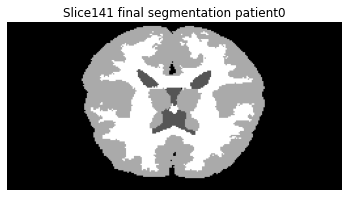

In [ ]:
# Check
slice_show(final_segmentations_majority_voting[0], 144, 'Slice141 final segmentation patient0')

In [ ]:
# Storing Final Segmentation Results using Majority Voting
pickle.dump(final_segmentations_majority_voting, open(saved_data+'/final_segmentations_majority_voting', 'wb'))

In [ ]:
test_results_directory = '/content/drive/MyDrive/Colab Notebooks/Final Project MISA/Test Results'
for index in range(len(final_segmentations_majority_voting)):
  current_test_results_directory = test_results_directory + '/' + test_images_names[index] + '_seg.nii.gz'
  current_seg_result = ArraytoSITK(final_segmentations_majority_voting[index], test_images_metadata[index])
  sitk.WriteImage(current_seg_result, current_test_results_directory)